# Homework 4

## Solutions by:

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.regression.rolling import RollingOLS
from itertools import product
import concurrent.futures
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

#################################
# Helper Functions (From HW3)
#################################

def get_sector_tickers(sectors_to_include=None, sectors_to_exclude=None):
    sp500_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    # Replace '.' with '-' to match Yahoo Finance tickers
    sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-')
    sp500_sectors = sp500_df[['Symbol', 'GICS Sector']]

    if sectors_to_include:
        sp500_sectors = sp500_sectors[sp500_sectors['GICS Sector'].isin(sectors_to_include)]
    if sectors_to_exclude:
        sp500_sectors = sp500_sectors[~sp500_sectors['GICS Sector'].isin(sectors_to_exclude)]

    return sp500_sectors.groupby('GICS Sector')['Symbol'].apply(list).to_dict()

def get_highly_correlated_pairs(corr_matrix, threshold=0.9):
    correlated_pairs = []
    tickers = corr_matrix.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            if corr_matrix.iloc[i, j] >= threshold:
                correlated_pairs.append((tickers[i], tickers[j]))
    return correlated_pairs

def find_cointegrated_pairs(data, pairs, significance_level=0.05):
    coint_pairs = []
    pvalues = []
    for pair in tqdm(pairs, desc="Testing Cointegration"):
        s1 = data[pair[0]]
        s2 = data[pair[1]]
        result = ts.coint(s1, s2)
        pvalue = result[1]
        if pvalue < significance_level:
            coint_pairs.append(pair)
            pvalues.append(pvalue)
    return coint_pairs, pvalues

def evaluate_strategy(data, pair, entry, exit, window):
    try:
        S1, S2 = pair
        pair_data = data[[S1, S2]].dropna()
        if len(pair_data) < window:
            return None, None  # Not enough data for rolling window
        Y = pair_data[S1]
        X = sm.add_constant(pair_data[S2])
        rolling_model = RollingOLS(Y, X, window=window)
        rolling_results = rolling_model.fit()
        hedge_ratios = rolling_results.params[S2]
        intercepts = rolling_results.params['const']
        spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        zscore = (spread - spread_mean) / spread_std

        # Define entry/exit logic
        long_entries = zscore < -entry
        long_exits = zscore > -exit
        short_entries = zscore > entry
        short_exits = zscore < exit

        positions_S1 = pd.Series(0, index=pair_data.index)
        positions_S2 = pd.Series(0, index=pair_data.index)

        for t in range(len(zscore)):
            if long_entries.iloc[t]:
                positions_S1.iloc[t] = 1
                positions_S2.iloc[t] = -hedge_ratios.iloc[t]
            elif short_entries.iloc[t]:
                positions_S1.iloc[t] = -1
                positions_S2.iloc[t] = hedge_ratios.iloc[t]
            elif long_exits.iloc[t] or short_exits.iloc[t]:
                positions_S1.iloc[t] = 0
                positions_S2.iloc[t] = 0
            else:
                if t > 0:
                    positions_S1.iloc[t] = positions_S1.iloc[t - 1]
                    positions_S2.iloc[t] = positions_S2.iloc[t - 1]

        returns_S1 = pair_data[S1].pct_change()
        returns_S2 = pair_data[S2].pct_change()
        strategy_returns = positions_S1.shift(1) * returns_S1 + positions_S2.shift(1) * returns_S2
        strategy_returns.fillna(0, inplace=True)
        
        if strategy_returns.std() == 0:
            return None, None

        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
        return strategy_returns, sharpe_ratio
    except Exception:
        return None, None

def parallel_evaluate(data, pair, entry_thresholds, exit_thresholds, rolling_windows):
    best_sharpe = -np.inf
    best_strategy = None
    best_params = None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(evaluate_strategy, data, pair, entry, exit, window): (entry, exit, window)
            for entry, exit, window in product(entry_thresholds, exit_thresholds, rolling_windows)
        }

        for future in concurrent.futures.as_completed(futures):
            entry, exit, window = futures[future]
            try:
                strategy_returns, sharpe = future.result()
                if sharpe is not None and sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_strategy = strategy_returns
                    best_params = (entry, exit, window)
            except Exception:
                pass

    return best_strategy, best_params, best_sharpe

## 1. Benchmark Definition and Data Collection

For our pairs trading strategy focused on the IT sector, we will use the Technology Select Sector SPDR Fund (XLK) as the benchmark. XLK is an ETF designed to track the performance of companies from the IT sector of the S&P 500. This makes it a suitable reference point to measure whether our strategy adds value relative to a simple "passive" exposure to the sector.


In [4]:
BENCHMARK_TICKER = "XLK"
START = "2015-01-01"
END = "2023-12-31"

included_sectors = ["Information Technology"] 
sector_tickers = get_sector_tickers(sectors_to_include=included_sectors)
# Limit to 10 tickers for faster processing but need to be changed by to entire sector
it_tickers = sector_tickers.get("Information Technology", [])

print("Selected IT Tickers for Strategy:")
display(it_tickers)

data = pd.DataFrame()
for ticker in tqdm(it_tickers, desc="Downloading IT Tickers"):
    try:
        df = yf.download(ticker, start=START, end=END, progress=False)
        if not df.empty:
            data[ticker] = df['Adj Close']
    except Exception as e:
        print(f"Could not download {ticker}: {e}")

data.dropna(axis=1, inplace=True)

if data.shape[1] < 2:
    raise ValueError("Not enough tickers with sufficient data.")

corr_matrix = data.corr().abs()
high_corr_pairs = get_highly_correlated_pairs(corr_matrix, threshold=0.9)
cointegrated_pairs, pvalues = find_cointegrated_pairs(data, high_corr_pairs)

coint_df = pd.DataFrame({
    'Pair': cointegrated_pairs,
    'P-Value': pvalues
}).sort_values('P-Value')

print("\nTop Cointegrated Pairs:")
display(coint_df.head())

if coint_df.empty:
    raise ValueError("No cointegrated pairs found. Can't build a pairs strategy.")

# Define parameter ranges (from HW3 approach)
entry_thresholds = np.arange(1.5, 3.1, 0.5)
exit_thresholds = np.arange(0.3, 1.1, 0.2)
rolling_windows = range(14, 43, 7)

# Optimize strategies for each pair
all_strategy_returns = pd.DataFrame()
best_results = []

for pair in tqdm(cointegrated_pairs, desc="Optimizing Pairs"):
    best_strategy, best_params, best_sharpe = parallel_evaluate(data, pair, entry_thresholds, exit_thresholds, rolling_windows)

    if best_strategy is not None:
        all_strategy_returns[pair] = best_strategy
        best_results.append((pair, *best_params, best_sharpe))

if not best_results:
    raise ValueError("No successful strategies found.")

best_results_df = pd.DataFrame(best_results, columns=['Pair', 'Entry Threshold', 'Exit Threshold', 'Rolling Window', 'Sharpe Ratio'])
print("\nTop Results Across All Pairs:")
display(best_results_df.sort_values('Sharpe Ratio', ascending=False))

# Construct a portfolio return as the mean of all strategies
portfolio_returns = all_strategy_returns.mean(axis=1)

Selected IT Tickers for Strategy:


['ACN',
 'ADBE',
 'AMD',
 'AKAM',
 'APH',
 'ADI',
 'ANSS',
 'AAPL',
 'AMAT',
 'ANET',
 'ADSK',
 'AVGO',
 'CDNS',
 'CDW',
 'CSCO',
 'CTSH',
 'GLW',
 'CRWD',
 'DELL',
 'ENPH',
 'EPAM',
 'FFIV',
 'FICO',
 'FSLR',
 'FTNT',
 'IT',
 'GEN',
 'GDDY',
 'HPE',
 'HPQ',
 'IBM',
 'INTC',
 'INTU',
 'JBL',
 'JNPR',
 'KEYS',
 'KLAC',
 'LRCX',
 'MCHP',
 'MU',
 'MSFT',
 'MPWR',
 'MSI',
 'NTAP',
 'NVDA',
 'NXPI',
 'ON',
 'ORCL',
 'PLTR',
 'PANW',
 'PTC',
 'QRVO',
 'QCOM',
 'ROP',
 'CRM',
 'STX',
 'NOW',
 'SWKS',
 'SMCI',
 'SNPS',
 'TEL',
 'TDY',
 'TER',
 'TXN',
 'TRMB',
 'TYL',
 'VRSN',
 'WDC',
 'ZBRA']

Testing Cointegration: 100%|██████████| 590/590 [00:52<00:00, 11.29it/s]


Top Cointegrated Pairs:


,Pair,P-Value
48,"(CDNS, SNPS)",0.000005
38,"(AAPL, MPWR)",0.000026
40,"(AMAT, NXPI)",0.000039
2,"(ACN, INTU)",0.000085
101,"(TER, TYL)",0.000099


Optimizing Pairs: 100%|██████████| 103/103 [21:54<00:00, 12.77s/it]


Top Results Across All Pairs:


,Pair,Entry Threshold,Exit Threshold,Rolling Window,Sharpe Ratio
28,"(ADI, MSFT)",2.5,0.3,21,1.029566
1,"(ACN, CDW)",2.0,0.3,35,0.973371
43,"(ADSK, CRM)",3.0,0.3,42,0.964824
47,"(CDNS, ORCL)",1.5,0.5,35,0.957422
25,"(ADI, CDW)",2.0,0.3,14,0.947389
...,...,...,...,...,...
95,"(QCOM, TER)",2.0,0.3,14,0.091389
70,"(LRCX, MPWR)",1.5,0.3,14,0.072774
22,"(APH, MPWR)",1.5,0.3,21,0.061084
94,"(QCOM, NOW)",2.5,0.5,14,-0.021565


In [5]:
print("\nIT data:")
display(data)


IT data:


,ACN,ADBE,AMD,AKAM,APH,ADI,ANSS,AAPL,AMAT,ANET,...,SNPS,TEL,TDY,TER,TXN,TRMB,TYL,VRSN,WDC,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,75.312737,72.339996,2.670000,63.250000,12.205962,45.276863,81.639999,24.347170,21.982449,3.917500,...,43.099998,52.534214,102.160004,18.383675,40.842278,26.910000,107.849998,57.189999,92.755753,77.430000
2015-01-05,74.041138,71.980003,2.660000,61.939999,11.982961,44.453499,80.860001,23.661274,21.277874,3.987500,...,42.540001,51.511311,99.720001,18.038397,40.208427,26.030001,105.970001,56.240002,91.529427,76.339996
2015-01-06,73.507065,70.529999,2.630000,60.669998,11.830495,43.410023,79.260002,23.663502,20.476435,3.988125,...,42.160000,50.887577,98.019997,17.487822,39.544010,25.660000,104.910004,55.180000,89.488335,75.790001
2015-01-07,75.049942,71.110001,2.580000,60.160000,12.033020,43.866550,79.709999,23.995316,20.670191,4.071250,...,42.209999,52.417786,98.790001,17.627792,40.254250,25.340000,106.029999,55.639999,90.832268,77.720001
2015-01-08,76.194382,72.919998,2.610000,61.570000,12.267396,44.640995,81.660004,24.917269,21.330717,4.132500,...,42.860001,53.473972,100.440002,18.178375,40.911026,25.670000,109.199997,56.880001,92.713730,79.379997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,348.842224,598.750000,139.600006,119.620003,49.198143,194.632874,357.980011,192.656189,160.794403,59.564999,...,524.460022,139.182907,433.450012,107.189682,163.579422,52.439999,415.000000,206.389999,52.660000,269.410004
2023-12-26,347.838348,598.260010,143.410004,119.480003,49.436649,196.380707,360.880005,192.108856,163.007141,59.382500,...,520.250000,139.538345,437.480011,109.898552,166.078217,53.189999,416.410004,206.830002,52.759998,275.500000
2023-12-27,348.222198,596.080017,146.070007,119.000000,49.426716,196.854706,358.899994,192.208359,162.937668,59.432499,...,518.099976,138.985443,441.730011,110.296921,166.486588,53.330002,415.600006,205.750000,52.419998,275.790009


In [6]:
xlk_data = yf.download(BENCHMARK_TICKER, start=START, end=END, progress=False)
xlk_data.dropna(inplace=True)

print("\nBenchmark (XLK) Data:")
display(xlk_data.head())



Benchmark (XLK) Data:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,41.610001,41.709999,41.060001,41.270000,36.498825,8495200
2015-01-05,41.119999,41.119999,40.520000,40.639999,35.941647,7194700
2015-01-06,40.759998,40.759998,39.959999,40.150002,35.508308,8745600
2015-01-07,40.459999,40.590000,40.200001,40.490002,35.808987,6534600
2015-01-08,40.820000,41.470001,40.759998,41.380001,36.596104,14211700


## 2. Returns Calculation:

In [7]:
it_returns = data.pct_change().dropna()

strategy_returns = it_returns.mean(axis=1)

xlk_data['XLK_Returns'] = xlk_data['Adj Close'].pct_change()
benchmark_returns = xlk_data['XLK_Returns'].dropna()

aligned_data = pd.concat([strategy_returns, benchmark_returns], axis=1, join='inner')
aligned_data.columns = ['Strategy_Returns', 'XLK_Returns']
aligned_data.dropna(inplace=True)

print("\nAligned Strategy and Benchmark Returns:")
display(aligned_data.head())


Aligned Strategy and Benchmark Returns:


,Strategy_Returns,XLK_Returns
Date,,
2015-01-05,-0.016127,-0.015266
2015-01-06,-0.018257,-0.012057
2015-01-07,0.009210,0.008468
2015-01-08,0.023691,0.021981
2015-01-09,-0.001728,-0.003142


## 3. Attribution Model Selection

The Brinson-Fachler model decomposes active portfolio returns into two primary sources: 
- Allocation effects : How the portfolio’s over/underweighting in certain sectors compares to a benchmark.
- Selection Effects: How security selection within a sector compares to the benchmark’s returns for that sector.

In our strategy, we are not making top-down allocation decisions across sectors; we are confined to a single sector. Thus, the allocation effect does not apply. We are not simply picking stocks to outperform a benchmark weight; we are trading relative-value spreads between pairs of stocks. The goal is to profit from mean reversion within a narrow subset of the sector, aiming for returns that are largely independent of the general market direction.

Given that our strategy is equity-based, a fixed-income attribution model would not be suitable either.

A more suitable model for attribution for us would be to use a regression-based performance attribution. 

To do so, we start by regressing the strategy’s returns on the benchmark returns to see how much of the strategy’s performance can be explained by the general movement of the IT sector. If a large portion of the variance in the strategy’s returns is explained by the benchmark, it suggests the strategy’s performance is largely driven by sector moves rather than pair-specific alpha.
After isolating the benchmark-driven portion, we can decompose the residual across the different pairs the strategy traded. For each pair, we regress the pair’s returns against the benchmark to determine its own unexplained component. We identify which pairs contribute most positively or negatively to the residual.

In [8]:
X = sm.add_constant(aligned_data['XLK_Returns'])
y = aligned_data['Strategy_Returns']
model = sm.OLS(y, X).fit()

alpha = model.params['const']
beta = model.params['XLK_Returns']
explained_by_benchmark = model.fittedvalues
unexplained_returns = aligned_data['Strategy_Returns'] - explained_by_benchmark

annualized_alpha = unexplained_returns.mean() * 252

print("\nOverall Strategy Attribution:")
print(f"Alpha (Daily): {alpha:.6f}")
print(f"Annualized Alpha: {annualized_alpha:.2%}")
print(f"Beta to Benchmark: {beta:.4f}")
print(f"R-squared: {model.rsquared:.4f}")

# Pair-level attribution
pair_contributions = []
for pair in all_strategy_returns.columns:
    pair_ret = all_strategy_returns[pair].dropna()

    pair_data = pd.concat([pair_ret, aligned_data['XLK_Returns']], axis=1, join='inner')
    pair_data.columns = ['Pair_Returns', 'XLK_Returns']
    pair_data.dropna(inplace=True)

    if pair_data.shape[0] < 30:
        continue

    X_pair = sm.add_constant(pair_data['XLK_Returns'])
    y_pair = pair_data['Pair_Returns']
    pair_model = sm.OLS(y_pair, X_pair).fit()

    pair_alpha = pair_model.params['const']
    pair_alpha_annualized = pair_alpha * 252
    pair_beta = pair_model.params['XLK_Returns']

    pair_contributions.append({
        'Pair': pair,
        'Pair Alpha (Daily)': pair_alpha,
        'Pair Alpha (Annualized)': pair_alpha_annualized,
        'Pair Beta to Benchmark': pair_beta,
        'Pair R-squared': pair_model.rsquared
    })

pair_contrib_df = pd.DataFrame(pair_contributions)
pair_contrib_df.sort_values('Pair Alpha (Annualized)', ascending=False, inplace=True)

print("\nPair-Level Attribution:")
display(pair_contrib_df)


pair_contrib_df['Contribution_to_Total_Alpha_%'] = (pair_contrib_df['Pair Alpha (Annualized)'] / annualized_alpha) * 100
print("\nPair Contribution to Total Alpha:")
display(pair_contrib_df[['Pair', 'Pair Alpha (Annualized)', 'Contribution_to_Total_Alpha_%']])



Overall Strategy Attribution:
Alpha (Daily): 0.000145
Annualized Alpha: 0.00%
Beta to Benchmark: 0.9781
R-squared: 0.8827

Pair-Level Attribution:


,Pair,Pair Alpha (Daily),Pair Alpha (Annualized),Pair Beta to Benchmark,Pair R-squared
0,"(ACN, AMD)",0.003052,0.768998,-0.001952,2.728825e-07
54,"(EPAM, TRMB)",0.001398,0.352421,-0.062517,3.218083e-04
15,"(AMD, LRCX)",0.001332,0.335703,0.073285,1.497361e-03
89,"(NXPI, ORCL)",0.001044,0.263168,0.027523,2.648847e-04
47,"(CDNS, ORCL)",0.000826,0.208144,0.014109,2.249112e-04
...,...,...,...,...,...
75,"(MCHP, MSI)",0.000002,0.000466,0.000036,3.564600e-05
94,"(QCOM, NOW)",-0.000005,-0.001230,-0.000664,5.991356e-06
70,"(LRCX, MPWR)",-0.000011,-0.002879,0.076188,9.570029e-03
22,"(APH, MPWR)",-0.000041,-0.010332,0.079214,3.069600e-02



Pair Contribution to Total Alpha:


,Pair,Pair Alpha (Annualized),Contribution_to_Total_Alpha_%
0,"(ACN, AMD)",0.768998,2.427366e+18
54,"(EPAM, TRMB)",0.352421,1.112428e+18
15,"(AMD, LRCX)",0.335703,1.059656e+18
89,"(NXPI, ORCL)",0.263168,8.306973e+17
47,"(CDNS, ORCL)",0.208144,6.570131e+17
...,...,...,...
75,"(MCHP, MSI)",0.000466,1.471411e+15
94,"(QCOM, NOW)",-0.001230,-3.883997e+15
70,"(LRCX, MPWR)",-0.002879,-9.086123e+15
22,"(APH, MPWR)",-0.010332,-3.261412e+16


*Note: the pair alpha can be interpreted as the selection effect from the Brinson-Fachler model*

The extremely small R-squared values at the pair level indicate that the pair returns are not well-explained by the benchmark. This can be expected in a mean-reverting pairs trading strategy since the primary driver of returns is the reversion of the spread, not the market direction.

The total alpha at the portfolio level is effectively zero - to be investigated.

## 4. Attribution Analysis

In our strategy, since we are already within one sector and pursuing a market-neutral strategy, we can think of the allocation effect as the portion of returns explained by the benchmark. Similarly, we can think of the selection effect as the alpha and residual returns from the pairs themselves, beyond what the benchmark explains.
In our single-sector, single-factor case, there’s effectively no multi-segment interaction. Any residual interaction is rolled into the unexplained portion. 

In [9]:
alpha = model.params['const']
beta = model.params['XLK_Returns']

strategy_daily = aligned_data['Strategy_Returns']
benchmark_daily = aligned_data['XLK_Returns']

allocation_component = beta * benchmark_daily

alpha_component = pd.Series(alpha, index=strategy_daily.index)
residual_component = strategy_daily - (alpha_component + allocation_component)

annual_allocation = allocation_component.mean() * 252
annual_alpha_component = alpha_component.mean() * 252
annual_residual = residual_component.mean() * 252

print(f"Annualized Allocation Effect (Explained by Benchmark): {annual_allocation:.4%}")
print(f"Annualized Selection Effect (Alpha + Residual): {(annual_alpha_component + annual_residual):.4%}")

cumulative_strategy = (1 + strategy_daily).cumprod() - 1
cumulative_allocation = (1 + allocation_component).cumprod() - 1
cumulative_alpha_residual = (1 + alpha_component + residual_component).cumprod() - 1

print("\nCumulative Returns (Over Entire Test Period):")
print(f"Cumulative Strategy Returns: {cumulative_strategy.iloc[-1]:.4%}")
print(f"Cumulative Allocation (Benchmark Explained) Returns: {cumulative_allocation.iloc[-1]:.4%}")
print(f"Cumulative Selection (Alpha+Residual) Returns: {cumulative_alpha_residual.iloc[-1]:.4%}")

Annualized Allocation Effect (Explained by Benchmark): 20.7516%
Annualized Selection Effect (Alpha + Residual): 3.6619%

Cumulative Returns (Over Entire Test Period):
Cumulative Strategy Returns: 584.4259%
Cumulative Allocation (Benchmark Explained) Returns: 408.6298%
Cumulative Selection (Alpha+Residual) Returns: 34.6457%


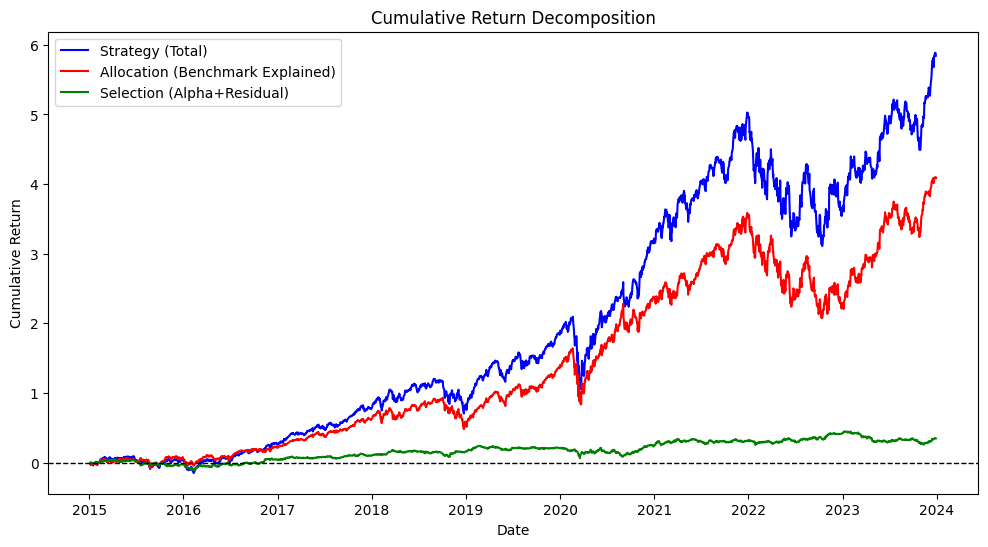

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumulative_strategy.index, cumulative_strategy, label='Strategy (Total)', color='blue')
ax.plot(cumulative_allocation.index, cumulative_allocation, label='Allocation (Benchmark Explained)', color='red')
ax.plot(cumulative_alpha_residual.index, cumulative_alpha_residual, label='Selection (Alpha+Residual)', color='green')
ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
ax.set_title('Cumulative Return Decomposition')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()

plt.show()

The strategy’s returns are overwhelmingly dominated by selection effects (idiosyncratic stock-pair trades) rather than general market moves (benchmark).

The bulk of our strategy’s returns are coming from alpha (idiosyncratic gains not explained by the benchmark) and residuals (likely the mean-reversion profits you earn from our pairs trades).

## 5. Insight Utilization and Communication

The analysis shows that the selection effect, modeled by alpha and residual effects, dominates the share of returns. In other words, our pair selection methodology to identifying cointegrated pairs, and timing of entries/exits is adding significant value beyond simple exposure to the IT sector via the benchmark. 

Given that the allocation (benchmark-driven) effect was negligible, the strategy is effectively market-neutral and does not rely heavily on the direction of the specific sector or the broader equity market. This is a positive sign since our goal is to produce returns uncorrelated with standard market movements. However, it also means performance is entirely contingent on the successful exploitation of pair relationships. 

However, realistically, we will need to consider transaction costs and slippage. Trading costs may then reduce some of the realized alpha, and could provide a more conservative estimate of returns. Also, cointegration relationships and spread dynamics may change over time, so a periodic re-calibration of pairs and parameters may be necessary. Finally, high selection-driven returns often come from a small set of pairs. Ensuring diversification across multiple pairs and having robust stop-loss mechanisms can help us mitigate idiosyncratic risk.

As a potential adjustment to the strategy, we could consider introducing other common equity risk factors such as size, value, or momentum to understand if our alpha is purely idiosyncratic or if it can be decomposed further into known factor exposures.

In [12]:
aligned_data

,Strategy_Returns,XLK_Returns
Date,,
2015-01-05,-0.016127,-0.015266
2015-01-06,-0.018257,-0.012057
2015-01-07,0.009210,0.008468
2015-01-08,0.023691,0.021981
2015-01-09,-0.001728,-0.003142
...,...,...
2023-12-22,0.005350,0.001303
2023-12-26,0.008495,0.004166
2023-12-27,-0.000621,-0.000052


In [22]:
from datetime import datetime
import holoviews as hv
import hvplot.pandas
hv.extension('bokeh')
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    def sortino_ratio(column):
        negative_returns = return_data[column][return_data[column] < 0]
        downside_std = np.sqrt((negative_returns ** 2).mean()) * np.sqrt(annualization)
        return summary_stats.loc[column, 'Mean'] / downside_std if downside_std != 0 else np.nan

    # Apply the sortino_ratio function to each column in return_data
    summary_stats['Sortino Ratio'] = return_data.apply(lambda col: sortino_ratio(col.name), axis=0)

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

def plot_dashboard(return_data):
    cumulative_returns = (1 + return_data).cumprod() - 1
    plot = cumulative_returns.hvplot.line(y='Strategy_Returns', label='Strategy Returns', color='blue', width=1200, height=400)* \
                cumulative_returns.hvplot.line(y='XLK_Returns', label='Benchmark Returns', color='red')
    plot.opts(title='Strategy vs. Benchmark Returns', xlabel='Date', ylabel='Cumulative Return', active_tools=['box_zoom'])

    summary_stats = performance_summary(return_data, 252)
    summary_table = hv.Table(summary_stats.reset_index()).opts(title='Performance Summary', width=1200)

    dashboard = (plot + summary_table).cols(1)
    
    return dashboard

plot_dashboard(aligned_data)

:Layout
   .Overlay.I :Overlay
      .Curve.Strategy_Returns  :Curve   [Date]   (Strategy_Returns)
      .Curve.Benchmark_Returns :Curve   [Date]   (XLK_Returns)
   .Table.I   :Table   [index,Mean,Volatility,Sharpe Ratio,Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery]